# Forecasting Time Series Patents Applications

Importing necessary pakages

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

# from dataclasses import dataclass

In [2]:
# def plot_series(time, series, format="-", start=0, end=None):
#     plt.plot(time[start:end], series[start:end], format)
#     plt.xlabel("Time")
#     plt.ylabel("Applications")
#     plt.grid(True)

In [3]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(20, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [4]:
filename = '../data/processed/applications_per_week.csv'

times = []
applications = []

with open(filename) as csvfile:
    
    reader = csv.reader(csvfile, delimiter=',')
    
    next(reader)
    
    for row in reader:
        times.append(float(row[0]))
        applications.append(float(row[2]))

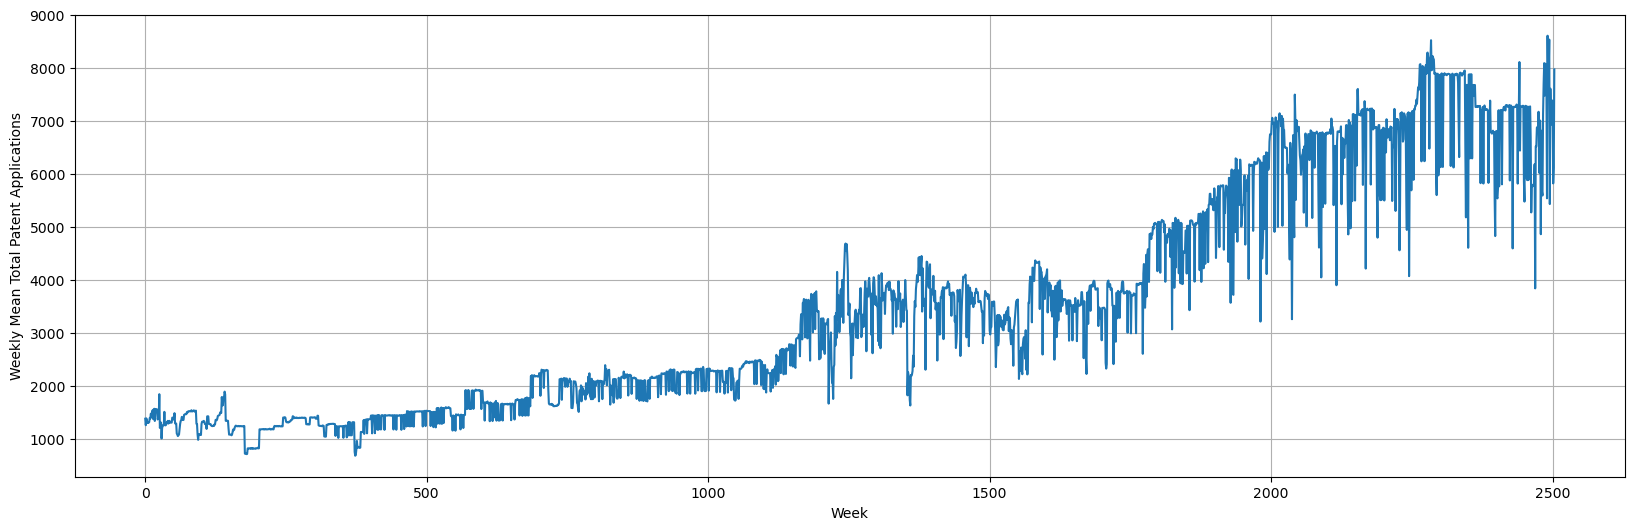

In [5]:
time = np.array(times)
series = np.array(applications)

plot_series(time, series, xlabel='Week', ylabel='Weekly Mean Total Patent Applications')

In [6]:
# Define the split time
split_time = 2250

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
# Parameters
# WINDOW_SIZE = 39
# BATCH_SIZE = 32
# SHUFFLE_BUFFER_SIZE = 500
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
# @dataclass
# class G:
#     # TEMPERATURES_CSV = '../data/processed/cleaned_data.xlsx'
#     PATENT_CSV = '../data/processed/applications_per_month.csv'
#     times, applications = parse_data_from_file(PATENT_CSV)
#     TIME = np.array(times)
#     SERIES = np.array(applications)
#     SPLIT_TIME = 480 # customizeable
#     WINDOW_SIZE = 39
#     BATCH_SIZE = 32
#     SHUFFLE_BUFFER_SIZE = 500
    
# time = np.array(G.times)
# series = np.array(G.applications)

# # Preview the data
# plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Patent Applications')

In [10]:
# def train_val_split(time, series, time_step=G.SPLIT_TIME):
#     time_train = time[:time_step]
#     x_train = series[:time_step]
#     time_valid = time[time_step:]
#     x_valid = series[time_step:]

#     return time_train, x_train, time_valid, x_valid

# # Split the dataset
# time_train, x_train, time_valid, x_valid = train_val_split(G.TIME, G.SERIES)

In [11]:
# def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     ds = ds.shuffle(shuffle_buffer)
#     ds = ds.map(lambda w: (w[:-1], w[-1]))
#     ds = ds.batch(batch_size).prefetch(1)
#     return ds


# # Apply the transformation to the training set
# train_set = windowed_dataset(x_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining Model Architecture

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                    strides=1,
                    activation="relu",
                    padding='causal',
                    input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 300)
])

## MONTH

# model = tf.keras.models.Sequential([ 
#     tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='causal', input_shape=[window_size, 1]),
#     tf.keras.layers.LSTM(32, return_sequences=True),
#     tf.keras.layers.LSTM(16),
#     tf.keras.layers.Dense(10),
#     tf.keras.layers.Dense(1),
#     tf.keras.layers.Lambda(lambda x: x * 100.0)
# ]) 

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 30)                990       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

## Adjusting Learning Rate

In [14]:
init_weights = model.get_weights()

In [15]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch /20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
70/70 [==============================] - 4s 22ms/step - loss: 3129.0728 - mae: 3129.5728 - lr: 1.0000e-08
Epoch 2/100
70/70 [==============================] - 1s 12ms/step - loss: 3107.7161 - mae: 3108.2161 - lr: 1.1220e-08
Epoch 3/100
70/70 [==============================] - 1s 14ms/step - loss: 3087.6497 - mae: 3088.1497 - lr: 1.2589e-08
Epoch 4/100
70/70 [==============================] - 1s 13ms/step - loss: 3054.6111 - mae: 3055.1111 - lr: 1.4125e-08
Epoch 5/100
70/70 [==============================] - 1s 14ms/step - loss: 3015.4670 - mae: 3015.9670 - lr: 1.5849e-08
Epoch 6/100
70/70 [==============================] - 1s 14ms/step - loss: 3006.4822 - mae: 3006.9822 - lr: 1.7783e-08
Epoch 7/100
70/70 [==============================] - 1s 18ms/step - loss: 2996.5730 - mae: 2997.0730 - lr: 1.9953e-08
Epoch 8/100
70/70 [==============================] - 1s 16ms/step - loss: 2988.2798 - mae: 2988.7798 - lr: 2.2387e-08
Epoch 9/100
70/70 [==============================] - 1s 

(1e-08, 0.001, 1000.0, 4000.0)

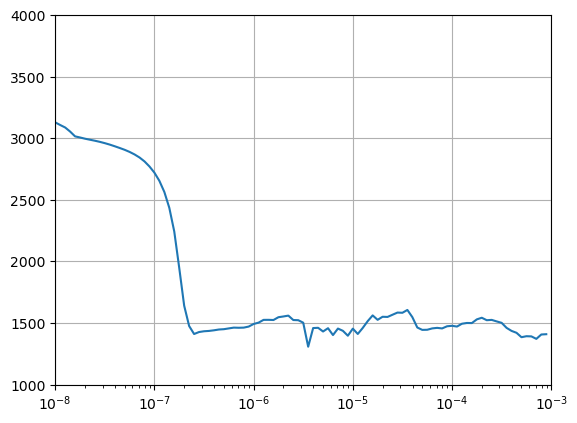

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.grid(True)
plt.axis([1e-8, 1e-3, 1000, 4000])

## Compile Model



In [17]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [18]:
# Set the learning rate
learning_rate = 7e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

In [19]:
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=['mae'])

## Train Model

In [20]:
history = model.fit(train_set, epochs=100)

Epoch 1/100
70/70 [==============================] - 8s 17ms/step - loss: 1790.9460 - mae: 1791.4460
Epoch 2/100
70/70 [==============================] - 1s 20ms/step - loss: 1303.9149 - mae: 1304.4149
Epoch 3/100
70/70 [==============================] - 2s 22ms/step - loss: 1375.8792 - mae: 1376.3789
Epoch 4/100
70/70 [==============================] - 1s 18ms/step - loss: 1426.5800 - mae: 1427.0797
Epoch 5/100
70/70 [==============================] - 2s 23ms/step - loss: 1414.9484 - mae: 1415.4484
Epoch 6/100
70/70 [==============================] - 2s 23ms/step - loss: 1435.6970 - mae: 1436.1969
Epoch 7/100
70/70 [==============================] - 2s 23ms/step - loss: 1456.0308 - mae: 1456.5306
Epoch 8/100
70/70 [==============================] - 2s 26ms/step - loss: 1445.2570 - mae: 1445.7570
Epoch 9/100
70/70 [==============================] - 2s 29ms/step - loss: 1440.1722 - mae: 1440.6722
Epoch 10/100
70/70 [==============================] - 2s 30ms/step - loss: 1514.3926 - mae:

## Result Plot

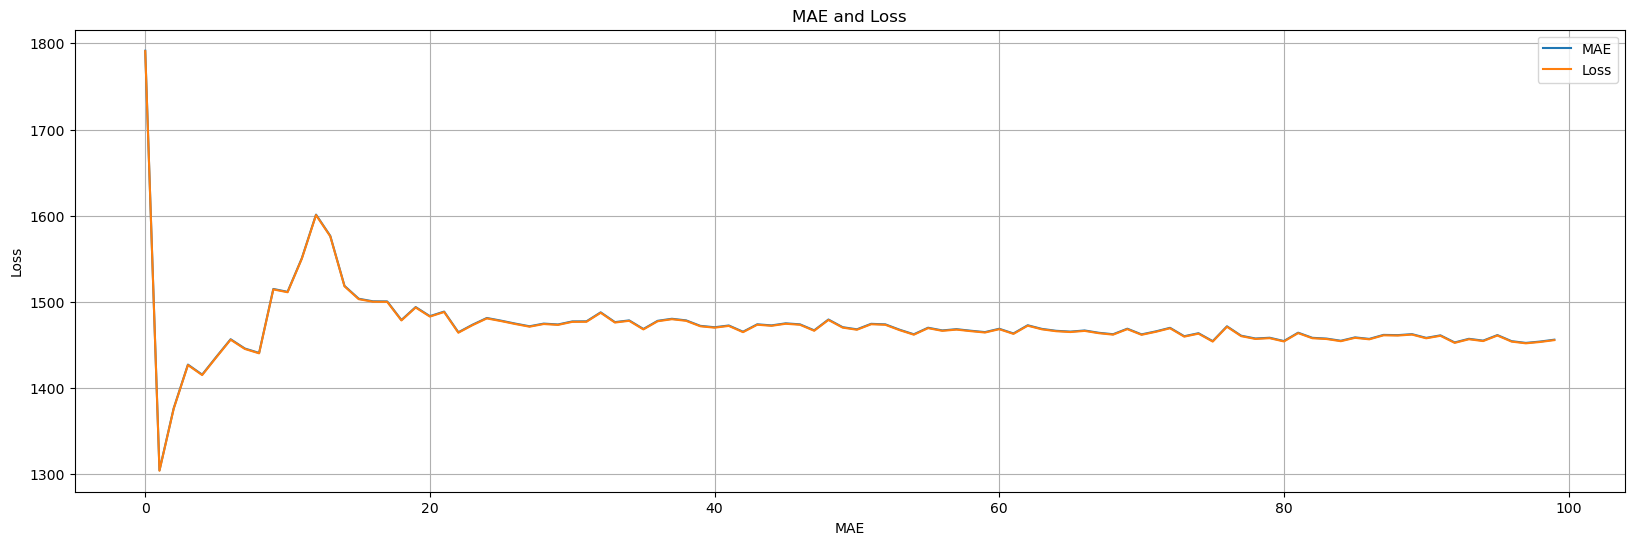

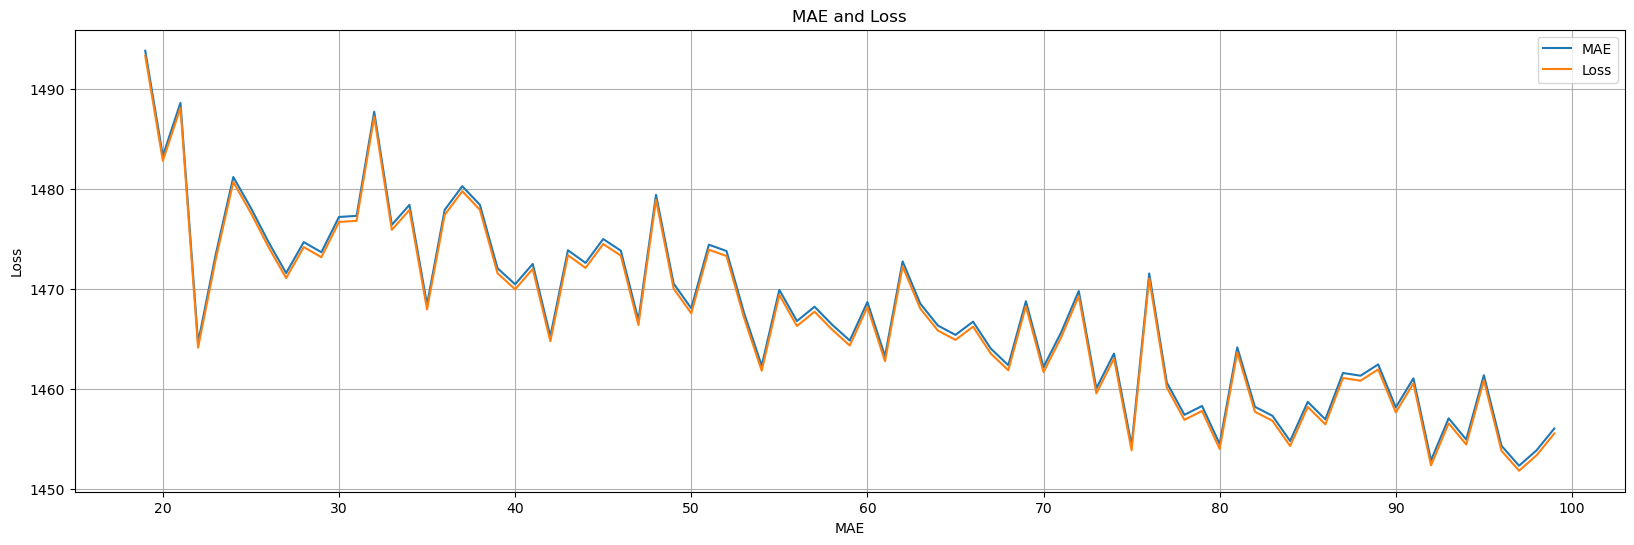

In [21]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Forecast

In [22]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 1s 13ms/step


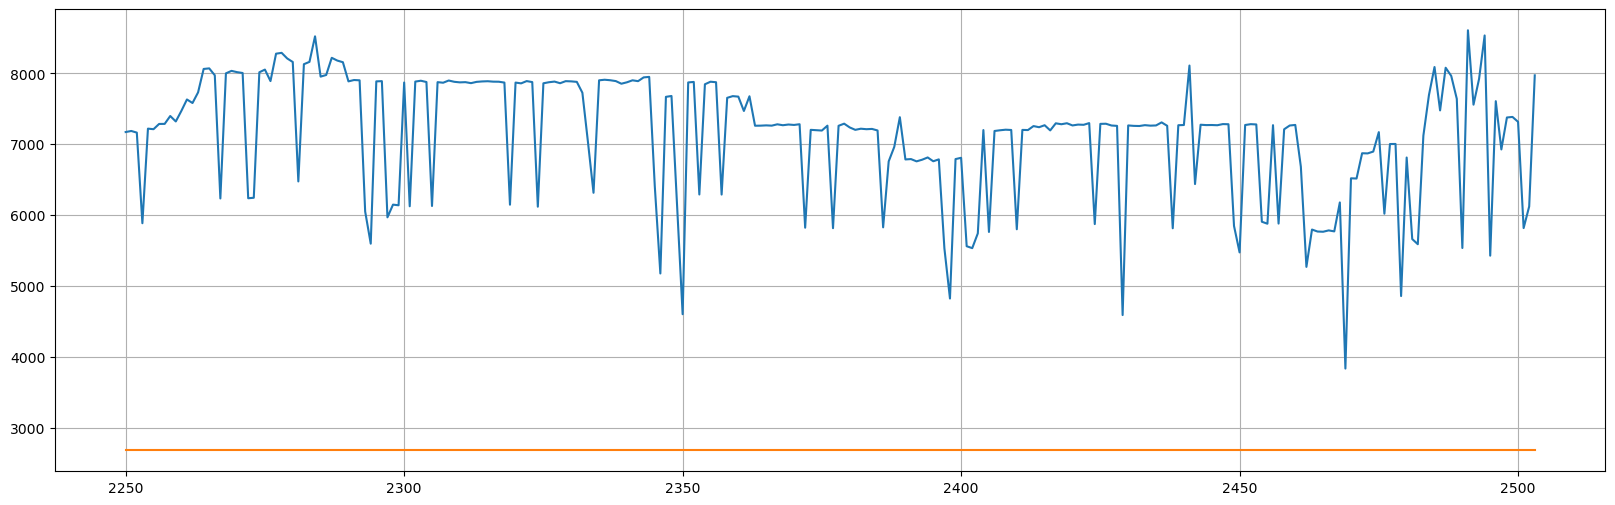

In [23]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

<Figure size 1000x600 with 0 Axes>

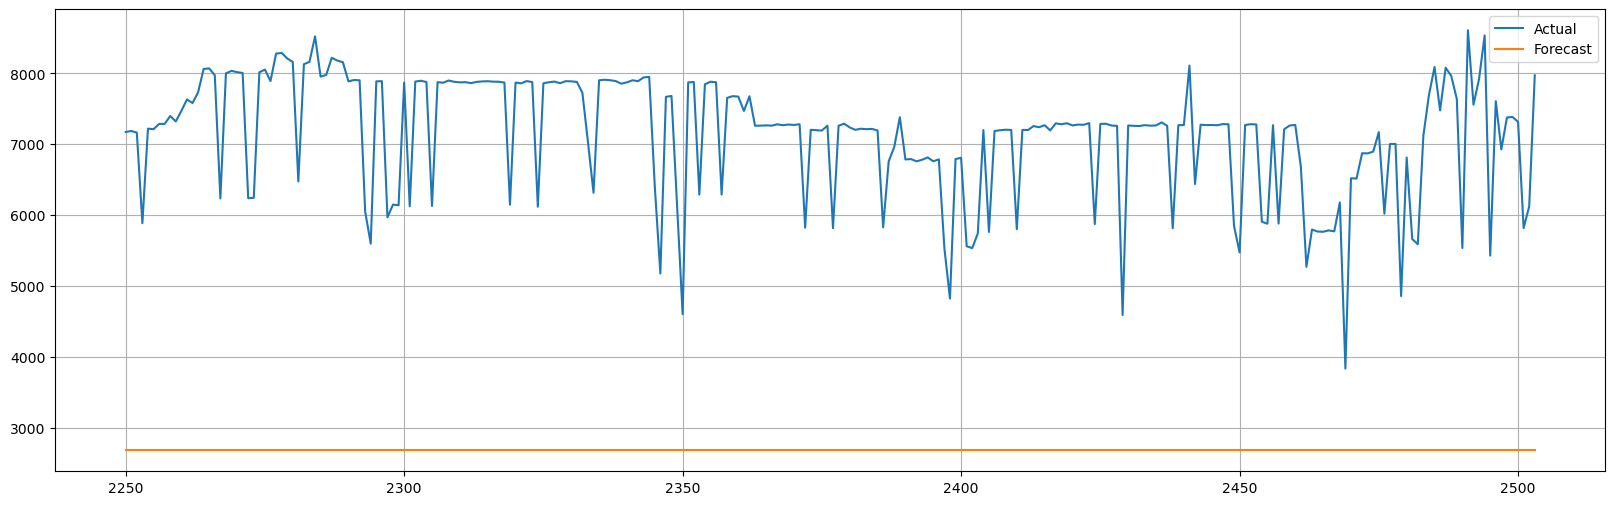

In [24]:
# Define labels for the legend
legend_labels = ['Actual', 'Forecast']

# Plot the original data and the forecasted results
plt.figure(figsize=(10, 6))
plot_series(time_valid, (x_valid, results), legend=legend_labels)

In [25]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

4451.096
